In [ ]:
# Install VELO SDK for easy API access
%pip install velo-sdk matplotlib polars python-dotenv --quiet


Note: you may need to restart the kernel to use updated packages.

In [20]:
# Set the figure format to SVG for plotting later
%config InlineBackend.figure_format = 'svg'

In [6]:
import os

import matplotlib.pyplot as plt
import polars as pl

from velo_sdk.api import APIClient

In [ ]:
try:
    from google.colab import auth, userdata
    auth.authenticate_user()
    os.environ["RISKTHINKING_API_KEY"] = userdata.get("RISKTHINKING_API_KEY")
except:
    # Not in Colab or error retrieving secret; skip Colab-specific logic
    pass

In [14]:
client = APIClient()  # VELO SDK auto detects $RISKTHINKING_API_KEY env var

company = client.companies.search_companies(name="Caterpillar", limit=1)[0]
company

Company(id='a11af66c-b148-4f7c-b4aa-c434bf00a957', name='Caterpillar Inc', slug='caterpillar-inc', headquarters_address="5205 North O'Connor Boulevard Suite 100, Irving, 75039, United States", organization_id=None, market_cap=178610000000, annual_revenue=59427000000, headquarters_country='US', sector='Industrials', isin_codes=['CA14913M1086', 'ARDEUT110079', 'US1491231015', 'BRCATPBDR003'], figi_codes=[], cik_code='', lei_code='', stock_tickers=['CAT_KZTQKD', 'CAT_KZ', 'CAT', 'CATP34', 'CATD', 'CAT *', 'CAT1', '4CAT', 'CATm', 'CATR', 'CATCL'], is_grandparent=None, data_generated_at=None, data_generation_status=None, created_at='2025-02-14T00:20:16.090695', updated_at='2025-04-29T22:03:46.167784')

In [15]:
horizons = [2025, 2075]
pathway = "RT3"
score_df = pl.DataFrame()
metric = "cvar_95"


for horizon in horizons:
    iterator = client.companies.list_company_asset_climate_scores(
        company_id=company.id,
        horizon=horizon,
        pathway=pathway,
        metric=metric
    )

    data = list(iterator)

    if data:
        df_chunk = pl.DataFrame(data).with_columns([
            pl.lit(horizon).alias("horizon"),
            pl.lit(pathway).alias("pathway")
        ])
        score_df = score_df.vstack(df_chunk)

In [16]:
asset_types = ["Machinery Manufacturing", "Wholesale Trade"]

df_filtered = score_df.filter(
    pl.col("asset_type").is_in(asset_types)
)

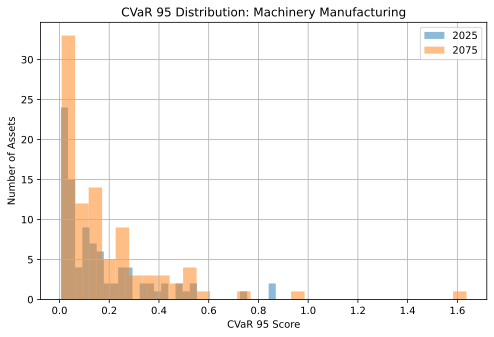

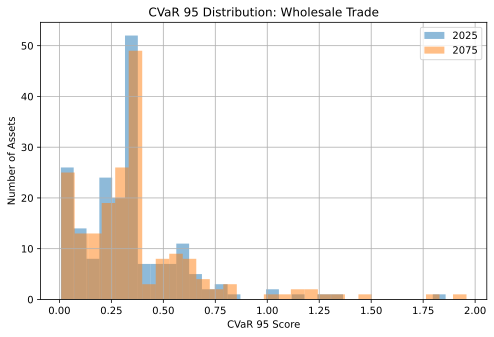

In [21]:
for asset_type in asset_types:
    fig, ax = plt.subplots(figsize=(8, 5))

    for year in horizons:
        subset = df_filtered.filter(
            (pl.col("asset_type") == asset_type) &
            (pl.col("horizon") == year)
        )

        cvar_values = subset["cvar_95"].to_numpy()

        ax.hist(cvar_values, bins=30, alpha=0.5, label=f"{year}")

    ax.set_title(f"CVaR 95 Distribution: {asset_type}")
    ax.set_xlabel("CVaR 95 Score")
    ax.set_ylabel("Number of Assets")
    ax.legend()
    ax.grid(True)
    plt.show()

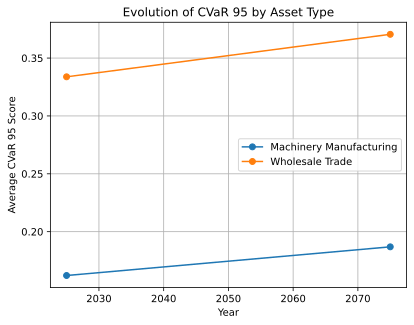

In [22]:
pivoted = (
    df_filtered
    .group_by(["asset_id", "asset_type", "horizon"])
    .agg(pl.col("cvar_95").mean().alias("cvar_95"))
    .pivot(values="cvar_95", index=["asset_id", "asset_type"], on="horizon")
)

for asset_type in ["Machinery Manufacturing", "Wholesale Trade"]:
    subset = pivoted.filter(pl.col("asset_type") == asset_type)

    mean_scores = [subset[str(year)].mean() for year in horizons]

    plt.plot(horizons, mean_scores, label=asset_type, marker="o")

plt.xlabel("Year")
plt.ylabel("Average CVaR 95 Score")
plt.title("Evolution of CVaR 95 by Asset Type")
plt.legend()
plt.grid(True)
plt.show()